In [33]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [34]:
import numpy as np
import pandas as pd
from pandas import DataFrame

In [35]:
#import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [36]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [37]:
# Setting up an engine

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [38]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [39]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [40]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [41]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis


2017-08-23
2016-08-23


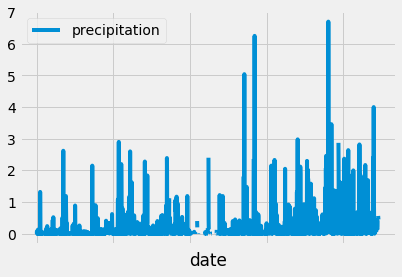

In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Compute the latest date in our dataset
latest_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

# Generate dates in YYYY-MM-DD format
latest_date=datetime.strptime(latest_date[0],'%Y-%m-%d').date()
print(latest_date)

# Calculate the date 1 year ago from the last data point in the database
year_ago_date=latest_date.replace(year=latest_date.year-1)
print(year_ago_date)

# Perform a query to retrieve the data and precipitation scores
prcp_data= session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=year_ago_date).filter(Measurement.date<=latest_date).all()
prcp_data

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data_df=DataFrame(prcp_data).set_index('date')
prcp_data_df=prcp_data_df.rename(columns={"prcp":"precipitation"})
prcp_data_df

# Sort the dataframe by date
prcp_data_df.sort_index(axis=0, ascending=False)
prcp_data_df

# Use Pandas Plotting with Matplotlib to plot the data
prcp_data_df.plot()
plt.legend(loc='best')



![precipitation](Images/precipitation.png)

In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [44]:
# Design a query to show how many stations are available in this dataset?

true_count_stations= session.query(Station.station).count()
true_count_stations


9

In [45]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_station=session.query(Measurement.station,func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
count_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [46]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#filter(Station.id == '7').\
Active_Station_lowest_highest_avg_temp=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                                        group_by(Measurement.station).\
                                        order_by(func.count(Measurement.station).desc()).first()
Active_Station_lowest_highest_avg_temp

(54.0, 85.0, 71.66378066378067)

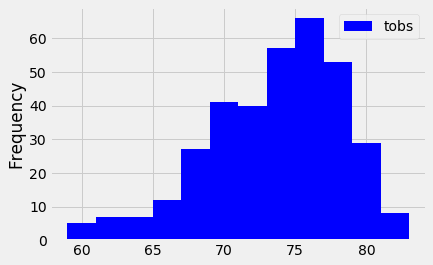

In [47]:
# Choose the station with the highest number of temperature observations.
# Determine the station and its counts first
Station_temp_count=session.query(Measurement.station,Station.id,func.count(Measurement.tobs)).\
                filter((Measurement.station== Station.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc()).first()
Station_temp_count

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data= session.query(Measurement.tobs).filter(Measurement.date>=year_ago_date).filter(Measurement.date<=latest_date).filter(Measurement.station==Station_temp_count[0]).all()
temp_data

# Convert team_data into a numpy array for plotting histogram graph
array_temp_data=np.asarray(temp_data)

# Plotting the histogram
plt.hist(x=array_temp_data, bins=12, color='blue', label='tobs')
plt.legend(loc='best')

#plt.grid(axis='x', alpha=0.75)
plt.ylabel('Frequency')

plt.show()

![precipitation](Images/station-histogram.png)


In [48]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [49]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#temp_char=calc_temps(year_ago_date, latest_date)

# Setting my vacation start and end dates as string and then converting into datetime format
vacation_start_date= '2018-05-01'
vacation_end_date= '2018-05-14'
vacation_start_date=datetime.strptime(vacation_start_date,'%Y-%m-%d').date()
vacation_end_date=datetime.strptime(vacation_end_date,'%Y-%m-%d').date()

# Computing exact year ago dates for analyzing temperature
vacation_start_date_analysis= vacation_start_date.replace(year=vacation_start_date.year-1)
vacation_end_date_analysis= vacation_end_date.replace(year=vacation_end_date.year-1)

# Computing the vacation temp data anlysis
vacation_temp_data=calc_temps(vacation_start_date_analysis, vacation_end_date_analysis)
#print(vacation_temp_data)
#print(type(vacation_temp_data))

# Since vacation_temp_data is a list of tuples, I am converting the tuple element into list
vacation_temp_data=list(vacation_temp_data[0])
vacation_temp_data
vacation_temp_data

[65.0, 75.21794871794872, 80.0]

([], <a list of 0 Text xticklabel objects>)

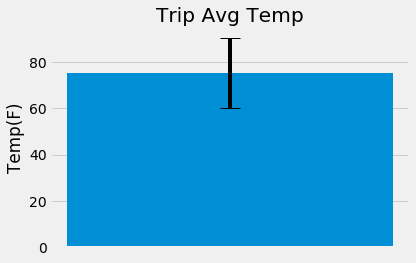

In [50]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos=1
tave=vacation_temp_data[1]
error= vacation_temp_data[2]-vacation_temp_data[0]
fig, ax=plt.subplots()
ax.bar(x_pos,tave,yerr=error,align='center',ecolor='black',capsize=10,width=0.8)
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp(F)')
plt.tight_layout()
plt.xticks([])


In [51]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_per_station=session.query(Measurement.station,Station.name,Station.latitude, Station.longitude, Station.elevation,func.avg(Measurement.prcp)).\
                filter((Measurement.station== Station.station)).\
                filter(Measurement.date >= vacation_start_date_analysis).filter(Measurement.date <= vacation_end_date_analysis).\
                group_by(Measurement.station).\
                order_by(func.avg(Measurement.prcp).desc()).all()
print(rainfall_per_station)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.32583333333333336), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.22214285714285717), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.21555555555555556), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.15785714285714283), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.057857142857142864), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02076923076923077)]


## Optional Challenge Assignment

In [52]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [53]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [54]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [28]:
# Plot the daily normals as an area plot with `stacked=False`
